In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns

In [2]:
experiment = 'data/original/*/*'

In [3]:
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean.set'))
eeg_present = len(eegs) > 0
all_present = mep_present and eeg_present
print(all_present)

True


In [4]:
eegs = [
    'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub04/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub10/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub11/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean.set'
]

In [5]:
# Read EEG file and prepare epochs in dataframes.
def read_eeg(path):
    epochs = read_epochs_eeglab(path)
    epochs = epochs.pick_channels(ch_names=['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'])
    epoch_list = []
    i = 0
    for epoch in epochs.iter_evoked():
        df = epoch.to_data_frame()
        epoch_list.append(df)
    return epoch_list

In [24]:
# Select EEG before TMS.
def crop_epochs(epoch_list, duration_millis=500, sampling_rate=1000):
    new_epoch_list = []
    for epoch_df in epoch_list:
        # Delete EEG after TMS event.
        epoch_df['signal time'] = epoch_df.index
        epoch_df = epoch_df.reset_index()
        indices = epoch_df.index[epoch_df['signal time'] == 0].tolist()
        event_index = int(len(indices)/2)
        delete_count = epoch_df.shape[0] - indices[event_index]
        epoch_df = epoch_df.drop(epoch_df.tail(delete_count).index)

        # Select EEG for the selected duration.
        keep = int(duration_millis * sampling_rate / 1000)
        delete_count = epoch_df.shape[0] - keep
        epoch_df = epoch_df.drop(epoch_df.head(delete_count).index)

        # Append the epoch in the list.
        epoch_df = epoch_df.set_index('signal time')
        new_epoch_list.append(epoch_df)
    return new_epoch_list, -keep

In [25]:
# Open MEP file as dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

In [26]:
# Function to get APB column name.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

In [27]:
# Function to crop MEP region.
def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

In [28]:
# Calculate MEP size.
def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size

In [29]:
# Calculate EEG area.
def calculate_eeg_area(epoch_df):
    gfp = np.sum(epoch_df ** 2, axis=1)
    times = gfp.index
    gfp = mne.baseline.rescale(gfp.values, times, baseline=(None, 0))
    return np.trapz(gfp, times)

In [30]:
# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 1000
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

In [31]:
def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

In [112]:
def filter_electrodes(epoch, which='lm1'):
    if which == 'ltm1':
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC2',
                'FC6', 'M1', 'T7', 'Cz', 'C4', 'T8', 'M2', 'CP2',
                'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FCz', 'FC4',
                'C2', 'C6', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)
    else:
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1',
                'M1', 'T7', 'C3', 'Cz', 'T8', 'M2', 'CP5', 'CP1',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'C5',
                'C1', 'CP3', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)

In [86]:
# Generate relations between EEG parameters and MEP sizes.
def generate_features(eeg_path, mep_path):
    raw_eeg = read_eeg(eeg_path)
    raw_eeg = filter_electrodes(raw_eeg)
    epoch_list, crop_length = crop_epochs(raw_eeg, 500)
    mep_frames = open_mep_as_df(mep_path)
    if (len(epoch_list) != len(mep_frames)):
        print('MEP and EEG epoch count did not match')
        return
    points = []
    for i in range(len(epoch_list)):
        mep_size = calculate_mep_size(mep_frames[i])
        eeg_area = calculate_eeg_area(epoch_list[i])
        freq = calculate_eeg_frequency(epoch_list[i])
        print('frequency is ' + str(freq))
        max_amplitude = calculate_eeg_max_amplitude(epoch_list[i])
        points.append((eeg_area, freq, max_amplitude, mep_size))
    mep_size_df = pd.DataFrame(points, columns=('area', 'freq', 'max_amplitude', 'mep'))
    return mep_size_df, raw_eeg, crop_length

In [87]:
def band_max(freq, psd, start=0, end=4):
    start = np.where(freq==start)
    if len(start) > 0:
        start = start[0][0]
    else:
        start = 0
    end = np.where(freq==end)
    if len(end) > 0:
        end = end[0][0]
    else:
        end = start + 4
    freq = freq[start:end]
    psd = psd[start:end]
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

In [105]:
freq

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290., 292., 294., 296., 298., 30

In [122]:
def extract_features(eeg_path, mep_path):
    epochs = read_eeg(eeg_path)
    epochs, _ = crop_epochs(epochs)
    mep_frames = open_mep_as_df(mep_path)
    if len(epochs) != len(mep_frames):
        raise Exception('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path)
        return
    epoch_features = []
    for i in range(len(epochs)):
        epoch = epochs[i]
        mep = mep_frames[i]
        segments = eeg_path.split('/')
        d = {'sub': segments[2], 'exp': segments[3], 'run': segments[5], 'epoch': i}

        freq, psd = calculate_eeg_frequency(epoch.drop('time', axis=1).values.mean(axis=1))
        d['all_all_max_power_freq'], d['all_all_max_power'] = band_max(freq, psd, 4, 40)
        d['all_delta_max_power_freq'], d['all_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['all_theta_max_power_freq'], d['all_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['all_alpha_max_power_freq'], d['all_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['all_beta_max_power_freq'], d['all_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['all_gamma_max_power_freq'], d['all_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'ltm1').values.mean(axis=1))
        d['ltm1_all_max_power_freq'], d['ltm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['ltm1_delta_max_power_freq'], d['ltm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['ltm1_theta_max_power_freq'], d['ltm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['ltm1_alpha_max_power_freq'], d['ltm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['ltm1_beta_max_power_freq'], d['ltm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['ltm1_gamma_max_power_freq'], d['ltm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'rtm1').values.mean(axis=1))
        d['rtm1_all_max_power_freq'], d['rtm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['rtm1_delta_max_power_freq'], d['rtm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['rtm1_theta_max_power_freq'], d['rtm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['rtm1_alpha_max_power_freq'], d['rtm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['rtm1_beta_max_power_freq'], d['rtm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['rtm1_gamma_max_power_freq'], d['rtm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        d['area_under_eeg'] = calculate_eeg_area(epoch.drop('time', axis=1))

        d['mep_size'] = calculate_mep_size(mep)
        epoch_features.append(d)
    return epoch_features

In [150]:
features = []
eegs_to_ignore = ['data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set', 
                  'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set']
for eeg_path in eegs:
    if (eeg_path in eegs_to_ignore):
        continue
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    features = features + extract_features(eeg_path, mep_path)

Extracting parameters from data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub04/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub06/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub07/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub08/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub10/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub11/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub13/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input leng

In [151]:
df = pd.DataFrame(features)
df.tail()

,all_all_max_power,all_all_max_power_freq,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,all_gamma_max_power,all_gamma_max_power_freq,...,rtm1_beta_max_power,rtm1_beta_max_power_freq,rtm1_delta_max_power,rtm1_delta_max_power_freq,rtm1_gamma_max_power,rtm1_gamma_max_power_freq,rtm1_theta_max_power,rtm1_theta_max_power_freq,run,sub
395,3.070459,6.0,2.520586,8.0,0.986132,20.0,2.620692,2.0,1.103089,100.0,...,0.125665,26.0,0.898686,2.0,1.181469,100.0,0.289339,6.0,SP 110RMT,sub13
396,0.638348,4.0,0.360533,10.0,0.539118,20.0,0.531366,2.0,1.131792,100.0,...,0.211488,16.0,0.077720,0.0,1.214964,100.0,0.024770,4.0,SP 110RMT,sub13
397,2.787538,6.0,2.763635,8.0,0.277856,20.0,1.918599,2.0,1.035143,100.0,...,0.099685,26.0,0.935069,2.0,1.162532,100.0,3.091663,4.0,SP 110RMT,sub13
398,5.071670,4.0,0.544242,12.0,0.738336,26.0,7.723836,2.0,0.981040,100.0,...,0.188359,22.0,2.069256,2.0,1.111546,100.0,3.837734,4.0,SP 110RMT,sub13
399,2.483447,18.0,0.492894,8.0,2.483447,18.0,0.375550,2.0,0.729317,100.0,...,0.276829,16.0,0.204073,2.0,0.970523,100.0,0.747829,4.0,SP 110RMT,sub13


In [152]:
df.columns

Index(['all_all_max_power', 'all_all_max_power_freq', 'all_alpha_max_power',
       'all_alpha_max_power_freq', 'all_beta_max_power',
       'all_beta_max_power_freq', 'all_delta_max_power',
       'all_delta_max_power_freq', 'all_gamma_max_power',
       'all_gamma_max_power_freq', 'all_theta_max_power',
       'all_theta_max_power_freq', 'area_under_eeg', 'epoch', 'exp',
       'ltm1_all_max_power', 'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
       'ltm1_alpha_max_power_freq', 'ltm1_beta_max_power',
       'ltm1_beta_max_power_freq', 'ltm1_delta_max_power',
       'ltm1_delta_max_power_freq', 'ltm1_gamma_max_power',
       'ltm1_gamma_max_power_freq', 'ltm1_theta_max_power',
       'ltm1_theta_max_power_freq', 'mep_size', 'rtm1_all_max_power',
       'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
       'rtm1_alpha_max_power_freq', 'rtm1_beta_max_power',
       'rtm1_beta_max_power_freq', 'rtm1_delta_max_power',
       'rtm1_delta_max_power_freq', 'rtm1_gamma_max_power',


Text(0, 0.5, 'MEP Size')

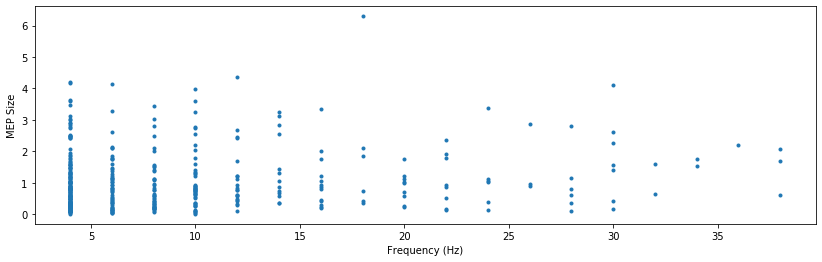

In [175]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_all_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

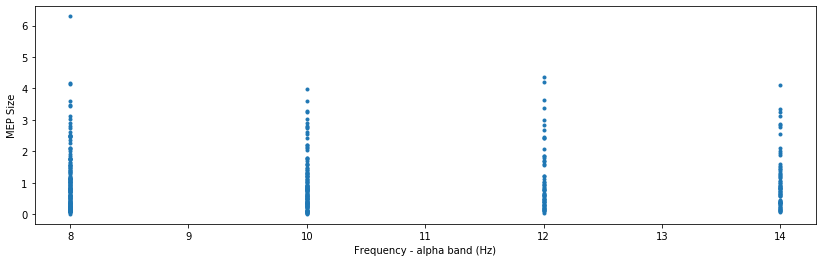

In [176]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_alpha_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

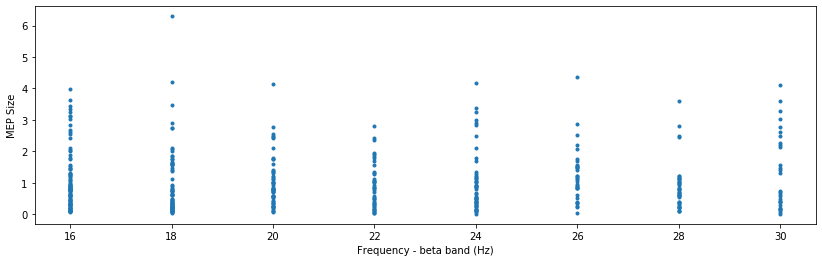

In [177]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_beta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - beta band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

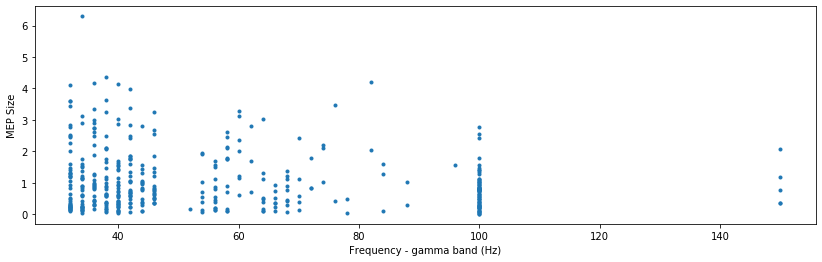

In [178]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_gamma_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - gamma band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

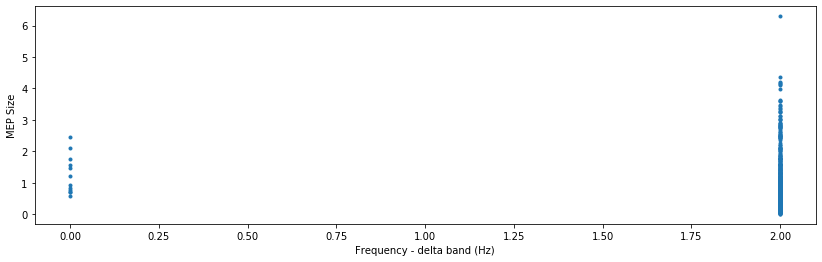

In [179]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_delta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - delta band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

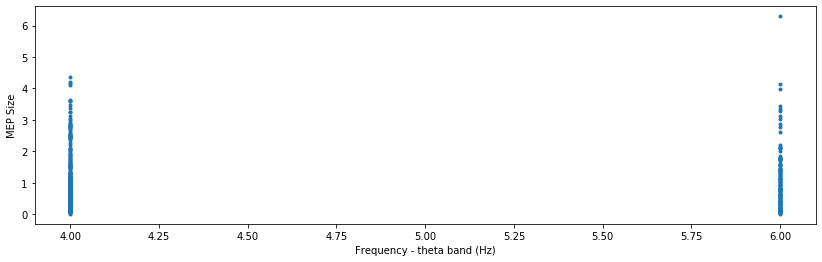

In [185]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_theta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - theta band (Hz)')
plt.ylabel('MEP Size')

In [180]:
df2 = df.groupby(['sub', 'exp', 'run']).mean()
df2.head()

,,,all_all_max_power,all_all_max_power_freq,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,all_gamma_max_power,all_gamma_max_power_freq,...,rtm1_alpha_max_power,rtm1_alpha_max_power_freq,rtm1_beta_max_power,rtm1_beta_max_power_freq,rtm1_delta_max_power,rtm1_delta_max_power_freq,rtm1_gamma_max_power,rtm1_gamma_max_power_freq,rtm1_theta_max_power,rtm1_theta_max_power_freq
sub,exp,run,,,,,,,,,,,,,,,,,,,,,
sub03,exp01,SP 110RMT r1,2.600773,9.48,1.753271,10.16,1.050128,20.24,2.167120,2.00,0.743320,87.64,...,2.886611,10.00,1.559353,20.84,5.959500,2.00,0.817214,59.32,4.144221,4.64
sub04,exp01,SP 110RMT r1,44.100969,11.72,24.202340,10.72,26.395078,21.88,72.780786,1.88,20.191874,46.60,...,68.251032,10.60,62.164819,21.68,204.106754,1.92,48.826627,48.16,72.887499,4.68
sub06,exp01,SP 110RMT r1,4.129349,7.68,3.654683,9.56,0.837222,19.64,2.026464,1.88,0.493285,45.00,...,4.973906,9.80,1.418235,19.92,3.517348,1.96,0.887064,42.32,3.565226,4.64
sub07,exp01,SP 110RMT r1,31.748715,7.64,18.652632,10.48,10.531344,20.16,62.016727,1.92,6.894438,67.04,...,106.187567,10.44,62.725740,20.60,366.753689,2.00,37.806419,48.32,172.147980,4.72
sub08,exp01,SP 110RMT r1,5.753799,8.88,2.617916,10.60,1.502017,21.68,10.028095,1.96,0.902747,46.12,...,8.820587,10.64,5.509516,21.60,36.667977,2.00,3.620606,46.60,16.458864,4.56


In [181]:
df2.shape

(8, 39)

Text(0, 0.5, 'MEP Size')

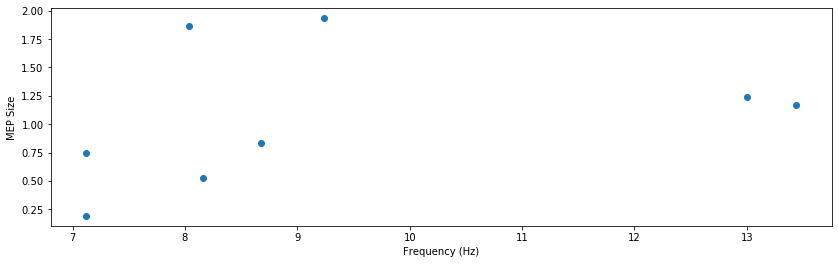

In [182]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_all_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

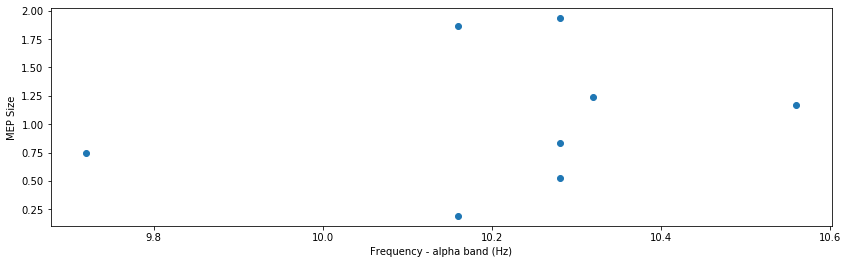

In [183]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_alpha_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')